# `epitope_aligner` cookbook
`epitope_aligner` makes it easy to map epitopes between sequences in an alignment.
This lets you combine epitopes from different sources and calculate
things like epitope density in a set of proteins.

Here we'll go through the available functions in detail. See the quick start guide for a complete example of using these functions together.

## Contents
- [Install](#install)
- [Background](#background)
    - [The big idea](#the-big-idea)
    - [Coordinate system](#coordinate-system)
    - [Naming conventions](#naming-conventions)
- [`align_coords`](#align-coordinates)
- [`unalign_coords`](#unaligning-coordinates)
- [`float_epitopes`](#float-epitopes)
    - [Alignment accuracy](#alignment-accuracy)
- [`locate_epitopes`](#locate-epitopes)
- [Analysis](#analysis)
    - [`stretch`](#stretch-epitopes)
    - [`make_grid`](#epitope-grids)
- [Utils](#utils)
- [Conclusion](#conclusion)

# Install
Install directly from github using one of:
- `pip install git+https://github.com/Vaccitech/epitope_aligner.git`
- `pip install git+git@github.com:Vaccitech/epitope_aligner.git`


# Background
## The big idea
The position of an epitope in an antigen can be encoded as a number coordinate (start/end position) or as an aligned sequence using gaps to pad the epitope sequence so the amino acids line up. Additionally, the antigen sequence that contains the epitope can be unaligned (no gaps) or aligned. This gives us four alternative ways to describe the position of a single epitope: coordinate in unaligned antigen, coordinate in aligned antigen, epitope sequence aligned to unaligned antigen, and epitope sequence aligned to aligned antigen.

Changing between these four types of position is not too complicated, but it is very easy to make a mistake when converting. That's why this package exists, to easily and reliable convert between these position types. The benefit of doing these convertions is to make it easy to combine information from epitopes in multiple related sequences.

To do this there are four core functions:
- `float_epitopes` converts coordinate to a sequence
- `locate_epitope` converts sequence to coordinates
- `align_coords` converts coordinate in *un*aligned sequence to coordinate in aligned sequence
- `unalign_coords` converts coordinate in aligned sequence to coordinate in *un*aligned sequence

By chaining these togther you can get from any position type to any other. For example you can get from coordinates in an *un*aligned sequence to an epitope sequence aligned to an antigen sequence. For this conversion you would use `align_coords` followed by `float_epitopes`.

## Coordinate system
One thing that can make coordinates tricky is that different people count their starts and ends in different ways.

To accomodate this we need to know two things:
- what we start counting positions from (index)
- and do we include the end position in the epitope.

Several `epitope_aligner` functions take these as arguments `index` and `includeend`.

### `index`
Do the position counts start at 0 or 1? If the first position in your protein is 0,
that's a zero-index. If the first position is 1, that's a 1-index.

Unless you've used zero indexes before, counting from 1 probably seems natural.
But lots of programming languages use zero indexes. Luckily, with epitope_aligner you
can use either. Just specify `index=0` or `index=1`. IEDB uses a 1-index,
whereas normal python sequences use a 0-index.

### `includeend`
Do you want to include the end position in the epitope? Again it's probably
natural for the end coordinate to be the last position in the epitope.
But in python when you take a "slice" from start to end, you don't include
the end position. In `epitope_aligner` functions you can specify whether your end
coordinate is inclusive or not with the `includeend` argument which takes
`True` or `False`.

IEDB do include the end coordinate in the epitope, whereas normal python slicing
does not. This means if there is an IEDB epitope "CDE" starting at position 3
and ending at position 5 (using IEDB coordinates) in sequence "abCDEfg", and
you ask python to slice position 3:5, you will not get the correct epitope sequence.


In [1]:
sequence = "abCDEfg"
start = 3
end = 5
sequence[start:end]

'DE'

This error happens because in python terms the epitope starts at position 2 (because of the zero-index)
and ends at position 5 (because the end position is not included in the epitope).

In [2]:
sequence[2:5]

'CDE'

## Naming conventions
This package is for handling the positions of epitopes within related antigen sequences. In function arguments `seq` refers to the epitope sequence and `parent_seq` refers to the antigen sequence.

If a function requires the sequence or parent sequence to be aligned the argument is `aligned_seq` or `aligned_parent_seq` respectively. Examples of this are `epitope_aligner.map.locate_epitope()` and `epitope_aligner.map.align_coordinates()`.

# Align coordinates

If we're looking at epitopes in several related sequences, we may want to
align those sequences and analyse the epitopes in that alignment.
To help with this `epitope_aligner` provides `align_coordinates()`,
this function converts coordinates in a sequence without gaps to coordinates
in a version of the same sequence with gaps.

Here's a set of example epitopes with start and end coordinates relative to the unaligned sequence. Note that in this example the coordinates use a zero-index and are not inclusive of the end position.

In [3]:
import pandas as pd
from epitope_aligner import map

# The aligned version of our sequence
aligned_seq = "ABCD--FGHIJKL--OP--STUVWXYZ"
# The unaligned version
seq = aligned_seq.replace("-","")
print(seq)

# A table of epitopes in sequence, positions are relative to the
# unaligned version
epitopes = pd.DataFrame({
        'start':[1,     4,      7,      10,     9,      11,     13],
        'end':  [4,     8,      11,     14,     13,     15,     17],
        'seq':  ["BCD", "FGHI", "IJKL", "LOPS", "KLOP", "OPST", "STUV"]
})
epitopes

ABCDFGHIJKLOPSTUVWXYZ


,start,end,seq
0,1,4,BCD
1,4,8,FGHI
2,7,11,IJKL
3,10,14,LOPS
4,9,13,KLOP
5,11,15,OPST
6,13,17,STUV


In [4]:
# epitope coords are correct
assert all(epitopes.apply(lambda x: seq[x.start:x.end]==x.seq, axis=1))

`align_coords()` takes the table of epitopes, the sequence you would
like coordinates aligned to, the coordinate column name, and a counting index. It returns the equivalent position in that aligned sequence. We can use this to get the aligned start and end positions.

In [5]:
epitopes['newstart'] = map.align_coords(
    table = epitopes,
    aligned_parent_seq = aligned_seq,
    coord_col = "start",
    index = 0
)
epitopes['newend'] = map.align_coords(
    table = epitopes,
    aligned_parent_seq = aligned_seq,
    coord_col = "end",
    index = 0
)
print(aligned_seq)
epitopes

ABCD--FGHIJKL--OP--STUVWXYZ


,start,end,seq,newstart,newend
0,1,4,BCD,1,6
1,4,8,FGHI,6,10
2,7,11,IJKL,9,15
3,10,14,LOPS,12,20
4,9,13,KLOP,11,19
5,11,15,OPST,15,21
6,13,17,STUV,19,23


We can verify that the new positions are correct by slicing these
new coordinates from the `aligned_seq`. Note that python slicing
uses a zero index, and does not include the end index. Our example
positions follow this form, but if you are using a different index
and/or including the end index, you will have to account for this
in your slicing.

In [6]:
epitopes['aligned_seq'] = epitopes.apply(lambda x: aligned_seq[x.newstart:x.newend], axis=1)
epitopes[['seq','aligned_seq']]

,seq,aligned_seq
0,BCD,BCD--
1,FGHI,FGHI
2,IJKL,IJKL--
3,LOPS,L--OP--S
4,KLOP,KL--OP--
5,OPST,OP--ST
6,STUV,STUV


In the above example all of the epitopes are from the same antigen, but what if the epitopes are from different antigens? To solve that we need a column saying which antigen each epitope is from and a dictionary of sequences.

Let's work through an example, and this time our example data will use a 1 index and coordinates will include the end. Therefore if you do any python slicing with these example coordinates you have to adjust them first, see [coordinate system](#coordinate-system) for more details.

In [7]:
# Two different aligned sequences
aligned_sequence1 = "ABC---DEFGH-IJK--LM"
aligned_sequence2 = "NO-PQR--STUVW-XYZ"

epitopes1 = pd.DataFrame({
        'start':  [2,      6,      9],
        'end':    [4,      9,      12],
        'seq':    ["BCD",  "FGHI", "IJKL"],
        "parent": ["seq1", "seq1", "seq1"]
})
epitopes2 = pd.DataFrame({
        'start':  [2,      5,        8,      10],
        'end':    [5,      7,        10,     13],
        'seq':    ["OPQR", "RST",    "UVW",  "WXYZ"],
        "parent": ["seq2", "seq2",   "seq2", "seq2"]
})

epitopes = pd.concat([epitopes1, epitopes2])
epitopes

,start,end,seq,parent
0,2,4,BCD,seq1
1,6,9,FGHI,seq1
2,9,12,IJKL,seq1
0,2,5,OPQR,seq2
1,5,7,RST,seq2
2,8,10,UVW,seq2
3,10,13,WXYZ,seq2


In [8]:
seq1 = aligned_sequence1.replace("-","")
seq2 = aligned_sequence2.replace("-","")
# epitope coords are correct
assert all(epitopes1.apply(lambda x: seq1[x.start-1:x.end-1+1]==x.seq, axis=1))
assert all(epitopes2.apply(lambda x: seq2[x.start-1:x.end-1+1]==x.seq, axis=1))

Next we need a dictionary to map the name in the `parent` column to the parent sequence.

In [9]:
parent_sequences = {
    'seq1': aligned_sequence1,
    'seq2': aligned_sequence2
}
print(parent_sequences)

{'seq1': 'ABC---DEFGH-IJK--LM', 'seq2': 'NO-PQR--STUVW-XYZ'}


Now we have our example data set up, a table of epitopes from different antigens and a dictionary of those antigens, we can call `align_coords`. The function call is very similar but we also include `parent_col` and we pass the dictionary as `aligned_parent_seq` rather than passing a sequence directly.

In [10]:
epitopes['newstart'] = map.align_coords(
    table= epitopes,
    aligned_parent_seq= parent_sequences,
    coord_col= "start",
    parent_col= "parent",
    index=1
)
epitopes['newend'] = map.align_coords(
    table= epitopes,
    aligned_parent_seq= parent_sequences,
    coord_col= "end",
    parent_col= "parent",
    index=1
)
print(f"seq1: {aligned_sequence1}")
print(f"seq2: {aligned_sequence2}")
epitopes

seq1: ABC---DEFGH-IJK--LM
seq2: NO-PQR--STUVW-XYZ


,start,end,seq,parent,newstart,newend
0,2,4,BCD,seq1,2,7
1,6,9,FGHI,seq1,9,13
2,9,12,IJKL,seq1,13,18
0,2,5,OPQR,seq2,2,6
1,5,7,RST,seq2,6,10
2,8,10,UVW,seq2,11,13
3,10,13,WXYZ,seq2,13,17


# Unaligning coordinates
You may want to go in the opposite direction, take coordinates in an aligned sequence and convert them to coordinates in the *un*aligned sequence. We do this with `unalign_coords()`. In this example our coordinates use a zero-index and the end is non-inclusive, see [coordinate system](#coordinate-system) for more details.

In [11]:
import pandas as pd
from epitope_aligner import map

# The aligned version of our sequence
aligned_seq = "ABCD--FGHIJKL--OP--STUVWXYZ"
print(aligned_seq)

# A table of epitopes in sequence, positions are relative to the
# aligned version
epitopes = pd.DataFrame({
        'aligned_start':[1,     6,      12,     11,     15,     19],
        'aligned_end':  [6,     10,     20,     19,     21,     23],
        'seq':          ["BCD", "FGHI", "LOPS", "KLOP", "OPST", "STUV"]
})
epitopes

ABCD--FGHIJKL--OP--STUVWXYZ


,aligned_start,aligned_end,seq
0,1,6,BCD
1,6,10,FGHI
2,12,20,LOPS
3,11,19,KLOP
4,15,21,OPST
5,19,23,STUV


In [12]:
epitopes['unaligned_start'] = map.unalign_coords(
    table=epitopes,
    aligned_parent_seq=aligned_seq,
    coord_col="aligned_start",
    index=0
)
epitopes['unaligned_end'] = map.unalign_coords(
    table=epitopes,
    aligned_parent_seq=aligned_seq,
    coord_col="aligned_end",
    index=0
)
epitopes

,aligned_start,aligned_end,seq,unaligned_start,unaligned_end
0,1,6,BCD,1,4
1,6,10,FGHI,4,8
2,12,20,LOPS,10,14
3,11,19,KLOP,9,13
4,15,21,OPST,11,15
5,19,23,STUV,13,17


In [13]:
# The unaligned version
seq = aligned_seq.replace("-","")
assert all(epitopes.apply(lambda x: seq[x['unaligned_start']:x['unaligned_end']], axis=1) == epitopes.seq)

As with the other `epitope_aligner` functions we can unalign coordinates for mulitple epitopes in multiple antigens at the same time. We need a column to identify the parent sequence of each epitope and a dictionary of those parent sequences. The values in the parent column should be the keys to get the correct sequence from the dictionary.

In [14]:
# Two different aligned sequences
aligned_sequence1 = "ABC---DEFGH-IJK--LM"
aligned_sequence2 = "NO-PQR--STUVW-XYZ"

aligned_parent_seqs = {
    'seq1': aligned_sequence1,
    'seq2': aligned_sequence2
}
print(aligned_parent_seqs)

epitopes1 = pd.DataFrame({
        'aligned_start':  [1,      8,      12],
        'aligned_end':    [7,      13,      18],
        'seq':    ["BCD",  "FGHI", "IJKL"],
        "parent": ["seq1", "seq1", "seq1"]
})
epitopes2 = pd.DataFrame({
        'aligned_start':  [1,      5,        10,      12],
        'aligned_end':    [8,      10,        14,     17],
        'seq':    ["OPQR", "RST",    "UVW",  "WXYZ"],
        "parent": ["seq2", "seq2",   "seq2", "seq2"]
})

epitopes = pd.concat([epitopes1, epitopes2])
epitopes

{'seq1': 'ABC---DEFGH-IJK--LM', 'seq2': 'NO-PQR--STUVW-XYZ'}


,aligned_start,aligned_end,seq,parent
0,1,7,BCD,seq1
1,8,13,FGHI,seq1
2,12,18,IJKL,seq1
0,1,8,OPQR,seq2
1,5,10,RST,seq2
2,10,14,UVW,seq2
3,12,17,WXYZ,seq2


In [15]:
epitopes['start'] = map.unalign_coords(
    table=epitopes,
    aligned_parent_seq=aligned_parent_seqs,
    coord_col="aligned_start",
    parent_col="parent",
    index=0
)
epitopes['end'] = map.unalign_coords(
    table=epitopes,
    aligned_parent_seq=aligned_parent_seqs,
    coord_col="aligned_end",
    parent_col="parent",
    index=0
)
epitopes

,aligned_start,aligned_end,seq,parent,start,end
0,1,7,BCD,seq1,1,4
1,8,13,FGHI,seq1,5,9
2,12,18,IJKL,seq1,8,12
0,1,8,OPQR,seq2,1,5
1,5,10,RST,seq2,4,7
2,10,14,UVW,seq2,7,10
3,12,17,WXYZ,seq2,9,13


In [16]:
assert all(epitopes.apply(lambda x: aligned_parent_seqs[x.parent].replace("-","")[x.start:x.end]==x.seq, axis=1))

One complexity that you may run into is the coordinates of gaps in an unaligned sequence. This doesn't really make sense since there are no gaps in an unaligned sequence, so why might you try it? The coordinate defining the end of your epitope could be a gap if your epitope is immediately followed by a gap and your coordinate system doesn't include the end position.

For example in the sequence `ABC--D` the epitope `ABC` starts at `0` and ends at `3` (If we use a zero index and do not include the end: `index=0` `includeend=False`). But the amino acid at the end position is a gap.

In [17]:
sequence = "ABC--D"
start = 0
end = 3
print(f"Epitope sequence from {start} to {end}: {sequence[start:end]}")
print(f"Amino acid at position {end}: {sequence[end]}")

Epitope sequence from 0 to 3: ABC
Amino acid at position 3: -


If we use `unalign_coords()` on a gap in this way we'll get a warning and it returns the coordinate of the next non-gap character after the gap.

In [ ]:
sequence = "ABC--D"
epitopes = pd.DataFrame({
    'start':[0],
    'end':[3],
    'seq':["ABC"],
})

map.unalign_coords(
    table=epitopes,
    aligned_parent_seq=sequence,
    coord_col="end",
    index=0
)

Coordinate of gap in ungapped sequence is ambiguous
Coordinate of next nongap character will be returned


0    3
dtype: int64

Luckily, you only have to keep this in mind if you define your own aligned coordinates. All of the `epitope_aligner` functions handle this in a coordinated way to you don't have to. For example if you generate aligned coordinates with `locate_epitope` or `align_coords` you wont run into this problem.

# Float epitopes
If you have epitope coordinates, you can easily "float" your epitopes so they
match up with the parent sequence. By "float" I mean add gaps before the epitope and respect gaps within the epitope in the parent sequence. I chose the term "float" instead of "align" to avoid confusion with sequence aligners which look for evolutionary similarity between amino acids; `float_epitopes` just respects the start position and the location of gaps.

Let's illustrate this with an example. Here is a sequence and a set of epitopes.

In [19]:
import pandas as pd
from epitope_aligner import map, utils

# The aligned version of our sequence
aligned_seq = "ABCD--FGHIJKL--OP--STUVWXYZ"
# The unaligned version
seq = aligned_seq.replace("-","")

# A table of epitopes in sequence, positions are relative to the
# unaligned version
epitopes = pd.DataFrame({
        'name': ['epiA', 'epiB', 'epiC', 'epiD', 'epiE', 'epiF', 'epiG'],
        'start':[1,      4,      7,      10,     9,      11,     13],
        'end':  [4,      8,      11,     14,     13,     15,     17],
        'seq':  ["BCD",  "FGHI", "IJKL", "LOPS", "KLOP", "OPST", "STUV"]
})
print(seq)
epitopes

ABCDFGHIJKLOPSTUVWXYZ


,name,start,end,seq
0,epiA,1,4,BCD
1,epiB,4,8,FGHI
2,epiC,7,11,IJKL
3,epiD,10,14,LOPS
4,epiE,9,13,KLOP
5,epiF,11,15,OPST
6,epiG,13,17,STUV


We can use `float_epitopes()` to float the epitopes so they line up with the parent seq. Here we're using the unaligned `seq` as the `parent_seq`. Remember to use the correct `index` for you data, see the [coordinate system](#coordinate-system) section for more details.

In [20]:
epitopes['float'] = map.float_epitopes(
    table=epitopes,
    parent_seq=seq,
    index=0,
)

print(seq)
for floating_epitope in epitopes.float:
    print(floating_epitope)

ABCDFGHIJKLOPSTUVWXYZ
-BCD
----FGHI
-------IJKL
----------LOPS
---------KLOP
-----------OPST
-------------STUV


If you use `id_col` to specify a column of the epitope dataframe, `float_epitopes()`
will return a list of Biopython SeqRecords. This can be saved out as a fasta or other
type of sequence alignment file.

In [21]:
map.float_epitopes(
    table=epitopes,
    parent_seq=seq,
    id_col="name",
    index=0,
)

[SeqRecord(seq=Seq('-BCD'), id='epiA', name='<unknown name>', description='<unknown description>', dbxrefs=[]),
 SeqRecord(seq=Seq('----FGHI'), id='epiB', name='<unknown name>', description='<unknown description>', dbxrefs=[]),
 SeqRecord(seq=Seq('-------IJKL'), id='epiC', name='<unknown name>', description='<unknown description>', dbxrefs=[]),
 SeqRecord(seq=Seq('----------LOPS'), id='epiD', name='<unknown name>', description='<unknown description>', dbxrefs=[]),
 SeqRecord(seq=Seq('---------KLOP'), id='epiE', name='<unknown name>', description='<unknown description>', dbxrefs=[]),
 SeqRecord(seq=Seq('-----------OPST'), id='epiF', name='<unknown name>', description='<unknown description>', dbxrefs=[]),
 SeqRecord(seq=Seq('-------------STUV'), id='epiG', name='<unknown name>', description='<unknown description>', dbxrefs=[])]

If your epitope table doesn't use "start" and "seq" columns
you can set custom column names.

In [22]:
epitopes = epitopes.copy()
epitopes.columns = [c.upper() for c in epitopes.columns]

map.float_epitopes(
    table=epitopes,
    parent_seq=seq,
    seq_col="SEQ",
    start_col="START",
    index=0,
)

['-BCD',
 '----FGHI',
 '-------IJKL',
 '----------LOPS',
 '---------KLOP',
 '-----------OPST',
 '-------------STUV']

We could also float the epitopes to line up with the aligned version of the parent sequence, as long as we have the start position in the aligned sequence. But don't worry, if you only have the start position in the unaligned `parent_seq` we can calculate it with `align_coords`!

In [23]:
# The aligned version of our sequence
aligned_seq = "ABCD--FGHIJKL--OP--STUVWXYZ"
# The unaligned version
seq = aligned_seq.replace("-","")

# A table of epitopes in sequence, positions are relative to the
# unaligned version
epitopes = pd.DataFrame({
        'start':[1,      4,      7,      10,     9,      11,     13],
        'end':  [4,      8,      11,     14,     13,     15,     17],
        'seq':  ["BCD",  "FGHI", "IJKL", "LOPS", "KLOP", "OPST", "STUV"]
})

epitopes['aligned_start'] = map.align_coords(
    table=epitopes,
    aligned_parent_seq=aligned_seq,
    coord_col="start",
    index=0
)
epitopes

,start,end,seq,aligned_start
0,1,4,BCD,1
1,4,8,FGHI,6
2,7,11,IJKL,9
3,10,14,LOPS,12
4,9,13,KLOP,11
5,11,15,OPST,15
6,13,17,STUV,19


Now we can float our epitopes to the aligned `parent_seq`. Note we use the aligned parent sequence as `parent_seq` and change `start_col` from its default value to `aligned_start` (the column we just created with `align_coords`).

In [24]:
epitopes['float_align'] = map.float_epitopes(
    table=epitopes,
    parent_seq=aligned_seq,
    start_col="aligned_start",
    index=0
)

print(aligned_seq)
for floating_epitope in epitopes.float_align:
    print(floating_epitope)

ABCD--FGHIJKL--OP--STUVWXYZ
-BCD
------FGHI
---------IJKL
------------L--OP--S
-----------KL--OP
---------------OP--ST
-------------------STUV


As with all of the `epitope_aligner` functions, we can float epitopes which are from different parent antigen sequences. To do this we pass a dictionary of parent sequences to `parent_seq` and we set `parent_col` to the name of a column which records which parent sequence to use for each epitopes.

We'll demonstrate this with a dataframe of epitopes from one of two sequences using 1 indexed coordinates which *do* include the end. Note that we have a column called `parent` which indicates which antigen the epitope is from.

In [25]:
# Two different sequences
seq1 = "ABCDEFGHIJKLM"
seq2 = "NOPQRSTUVWXYZ"

# Epitopes for those sequences
epitopes1 = pd.DataFrame({
        'start':  [2,      6,      9],
        'end':    [4,      9,      12],
        'seq':    ["BCD",  "FGHI", "IJKL"],
        "parent": ["seq1", "seq1", "seq1"]
})
epitopes2 = pd.DataFrame({
        'start':  [2,      5,        8,      10],
        'end':    [5,      7,        10,     13],
        'seq':    ["OPQR", "RST",    "UVW",  "WXYZ"],
        "parent": ["seq2", "seq2",   "seq2", "seq2"]
})

epitopes = pd.concat([epitopes1, epitopes2])
epitopes

,start,end,seq,parent
0,2,4,BCD,seq1
1,6,9,FGHI,seq1
2,9,12,IJKL,seq1
0,2,5,OPQR,seq2
1,5,7,RST,seq2
2,8,10,UVW,seq2
3,10,13,WXYZ,seq2


Next we'll make a dictionary out of the antigen sequences using the sequence names as keys.

In [26]:
parent_seqs = {
    "seq1": seq1,
    "seq2": seq2,
}
parent_seqs

{'seq1': 'ABCDEFGHIJKLM', 'seq2': 'NOPQRSTUVWXYZ'}

Now we're ready to float the epitopes to their respecitve parent sequences.

In [27]:
epitopes['float'] = map.float_epitopes(
    table=epitopes,
    parent_seq=parent_seqs,
    parent_col="parent",
    index=1,
)

for i,row in epitopes.iterrows():
    print(parent_seqs[row.parent])
    print(row.float)
    print()

ABCDEFGHIJKLM
-BCD

ABCDEFGHIJKLM
-----FGHI

ABCDEFGHIJKLM
--------IJKL

NOPQRSTUVWXYZ
-OPQR

NOPQRSTUVWXYZ
----RST

NOPQRSTUVWXYZ
-------UVW

NOPQRSTUVWXYZ
---------WXYZ



## Alignment accuracy
You can score how well a floating epitopes matches it's parent sequence.
This is useful to identify epitopes that don't match their parent sequence,
or low scores can indicate the wrong index.

The alignment score can be calculated with `score_epitope_alignment()`.
This function compares the value in `seq_col` with the `parent_seq`.
The value in `seq_col` should be the epitope sequence floated to match the parent sequence.
It returns a data frame with columns `score` and `matches`. `score` is the proportion of non-gap matches between epitope and parent sequence. `matches` is a list of booleans for matches.

In [28]:
map.score_epitope_alignments(
    table=epitopes,
    seq_col="float",
    parent_seq=parent_seqs,
    parent_col="parent"
)

,score,matches
0,1.0,"[True, True, True]"
1,1.0,"[True, True, True, True]"
2,1.0,"[True, True, True, True]"
0,1.0,"[True, True, True, True]"
1,1.0,"[True, True, True]"
2,1.0,"[True, True, True]"
3,1.0,"[True, True, True, True]"


# Locate epitopes
Given epitopes that have been aligned to a parent sequence, for example the output of `float_epitopes`,
what are the coordinates of the epitopes in that alignment?

We can use `locate_epitopes()` for this. It returns the first and last non-gap positions for each epitope.
With the arguments `index` and `includeend` we can set which coordinate system we want to use (see the [coordinate system](#coordinate-system) section for more details).

Unlike most of the other `epitope_aligner` functions `locate_epitope` can be applied directly to a sequence string and it doesn't need to know the sequence of the parent antigen. Here's an example using zero indexing where the end is not included.

In [29]:
from epitope_aligner import map
import pandas as pd

aligned_seq = "--CD-F"
location = map.locate_epitope(
    aligned_seq=aligned_seq,
    index=0,
    includeend=False
)
print(aligned_seq)
print(location)

--CD-F
(2, 6)


Python uses zero indexes and slicing doesn't include the end position, as in the example above. However, if you want the location in the IEDB format (1 index and end position included in the epitope) you can set `index=1` and `includeend=True`.

In [30]:
location = map.locate_epitope(
    aligned_seq=aligned_seq,
    index=1,
    includeend=True
)
print(aligned_seq)
print(location)

--CD-F
(3, 6)


Let's demonstrate with a whole table of aligned epitopes.

In [31]:
epitopes = pd.DataFrame({
    'aligned_seq': ["abc", "--cdef", "-----fghi", "--cdef---", "--cd-f---"]
})
epitopes['seq'] = epitopes.aligned_seq.str.replace("-","")
epitopes


,aligned_seq,seq
0,abc,abc
1,--cdef,cdef
2,-----fghi,fghi
3,--cdef---,cdef
4,--cd-f---,cdf


In [32]:
location = epitopes['aligned_seq'].apply(map.locate_epitope, index=0, includeend=False)
epitopes[['start','end']] = pd.DataFrame(location.tolist())
epitopes

,aligned_seq,seq,start,end
0,abc,abc,0,3
1,--cdef,cdef,2,6
2,-----fghi,fghi,5,9
3,--cdef---,cdef,2,6
4,--cd-f---,cdf,2,6


# Analysis
With the functions describe above, `float_epitopes`, `locate_epitopes`, `align_coords`, and `unalign_coords` we can put all of our epitopes into a common coordinate system and aligned to whatever sequences we like. Which means we can now start to analyse our epitopes!

This section describes how to aggregate your epitopes to calculate things like epitope density and how to visualise your new epitope locations.

Let's start by generating some random epitopes, see the section on [utils](#utils) for more details about generating random epitopes and sequences.

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from epitope_aligner import map, stretch, utils

sequence = utils.random_seq(20)
epitopes = utils.random_epitopes(sequence, n=3, epitope_lengths=(3,6), index=0, includeend=False)

print(sequence)
epitopes

GNAGMEPIPVYMCCTPTGIT


,start,end,seq,length
0,2,6,AGME,4
1,11,14,MCC,3
2,0,5,GNAGM,5


An nice start point is to plot the locations of each epitope. With `plot_line()`,
each epitope is plotted as a horizontal line from its start to its end coordinate.
The position on the y axis is based on the column name passed to the `y` argument.

For simplicity we have used the start position but it could be anything you have
such as binding affinity or response frequency. We also haven't added any labels but that can be done the same was as for any matplotlib plot. See the quick start guide for an example using colour.

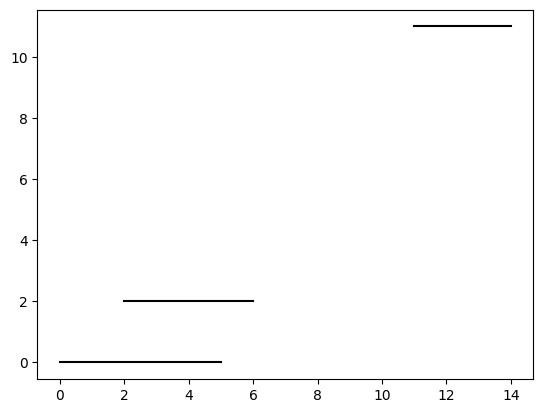

In [44]:
utils.plot_line(epitopes, y="start", c="black")
plt.show()

## Stretch epitopes
If we want to focus, not on individual epitopes, but all epitopes at a position,
we can use the `stretch()` function. This function "stretches" the epitopes so we have
a record for each position the epitope overlaps. This means that instead of each row being an epitope, each row is a position occupied by a given epitope.
Effectively duplicating each row for each residue in the epitope
and adding a column indicating the position of that residue. This is useful because we can then group epitopes by their overlapping positions.

In [45]:
stretched_epitopes = stretch.stretch(epitopes)
stretched_epitopes

,start,end,seq,length,position,residue
2,0,5,GNAGM,5,0,G
2,0,5,GNAGM,5,1,N
2,0,5,GNAGM,5,2,A
2,0,5,GNAGM,5,3,G
2,0,5,GNAGM,5,4,M
0,2,6,AGME,4,2,A
0,2,6,AGME,4,3,G
0,2,6,AGME,4,4,M
0,2,6,AGME,4,5,E
1,11,14,MCC,3,11,M


This allows us to assess all the epitopes at a given position
Use groupby on the new position column and then apply whatever function you like.

For example, `size` counts the number of epitopes overlapping a given position. There is another example later in this notebook, or look up pandas `groupby` for more detail on these type of functions.

In [46]:
positional_count = stretched_epitopes.groupby("position").size()
positional_count

position
0     1
1     1
2     2
3     2
4     2
5     1
11    1
12    1
13    1
dtype: int64

Note that there are not records for positions without any epitopes
But we can add them with `add_empty_positions()`.

In [48]:
positional_count = stretch.add_empty_positions(
    positional_count,
    parent_seq_length=len(sequence),
    index=1,
    empty_value=0
)

Now we have the number of epitopes overlapping each position in the parent sequence.
We can easily plot this to see which regions are epitope rich.

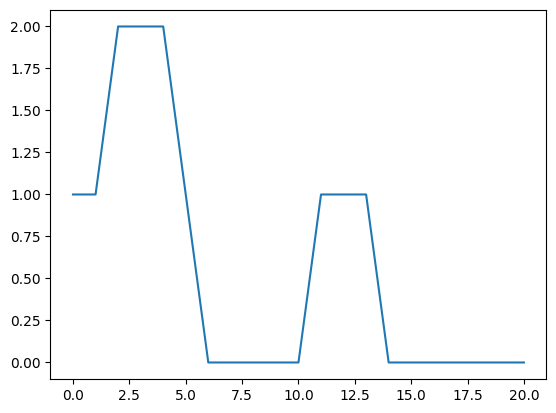

In [49]:
plt.plot(positional_count)
plt.show()

## Epitope grids
`stretch()` prepares epitope data so we can group them by position, but what if we want to group them by position and some other variable, eg MHC allele? For that we can make an epitope grid using `make_grid()`. This lets us compare epitopes along the protein between groups. For example we may reveal the one region is particularly rich in epitopes for a recognised by a set of MHC alleles associated with a disease.

Create some random epitopes and create a new column for fictional MHC alleles that recognise these epitopes.

In [50]:
sequence = utils.random_seq(10)
epitopes = utils.random_epitopes(sequence, n=5, epitope_lengths=(3,6), index=0, includeend=False)
epitopes['mhc_allele'] = ["x","x","y","z","z"]

print(sequence)
epitopes

WVTVRLEWAI


,start,end,seq,length,mhc_allele
0,2,5,TVR,3,x
1,5,8,LEW,3,x
2,0,4,WVTV,4,y
3,3,7,VRLE,4,z
4,0,4,WVTV,4,z


Now we stretch the epitopes, same as before.

In [51]:
stretched_epitopes = stretch.stretch(epitopes)

This is an example of some more interesting groupby functions we can apply.

In [52]:
stretched_epitopes.groupby("position").agg(
    # Average start position of epitopes overlapping this position
    mean_start=('start', "mean"),
    # number of unique mhc alleles with epitopes at this position
    n_alleles = ('mhc_allele', lambda x: len(set(x)))
)

,mean_start,n_alleles
position,,
0,0.000000,2
1,0.000000,2
2,0.666667,3
3,1.250000,3
4,2.500000,2
5,4.000000,2
6,4.000000,2
7,5.000000,1


Lets use groupby to count the number of epitopes for each MHC allele, at each position.

In [53]:
allele_position_count = stretched_epitopes.groupby(["mhc_allele", "position"]).size()
allele_position_count

mhc_allele  position
x           2           1
            3           1
            4           1
            5           1
            6           1
            7           1
y           0           1
            1           1
            2           1
            3           1
z           0           1
            1           1
            2           1
            3           2
            4           1
            5           1
            6           1
dtype: int64

The above result doesn't have values for all position-allele combinations. We can add them using `add_empty_positions()`.
Or we can use `make_grid()` which automatically fills in missing values. In this example each column is a position, each row is an mhc_allele, and each value is the number of epitopes for that mhc_allele at that position.

In [55]:
grid = stretch.make_grid(
    allele_position_count,
    index=0,
    parent_seq_length=len(sequence),
    empty_value=0
)

grid

0                           
position    0  1  2  3  4  5  6  7  8  9
mhc_allele                              
y           1  1  1  1  0  0  0  0  0  0
x           0  0  1  1  1  1  1  1  0  0
z           1  1  1  2  1  1  1  0  0  0

We can plot this matrix easily using `matplotlib` which is very useful for viewing this
type of grids for lots of MHC alleles.

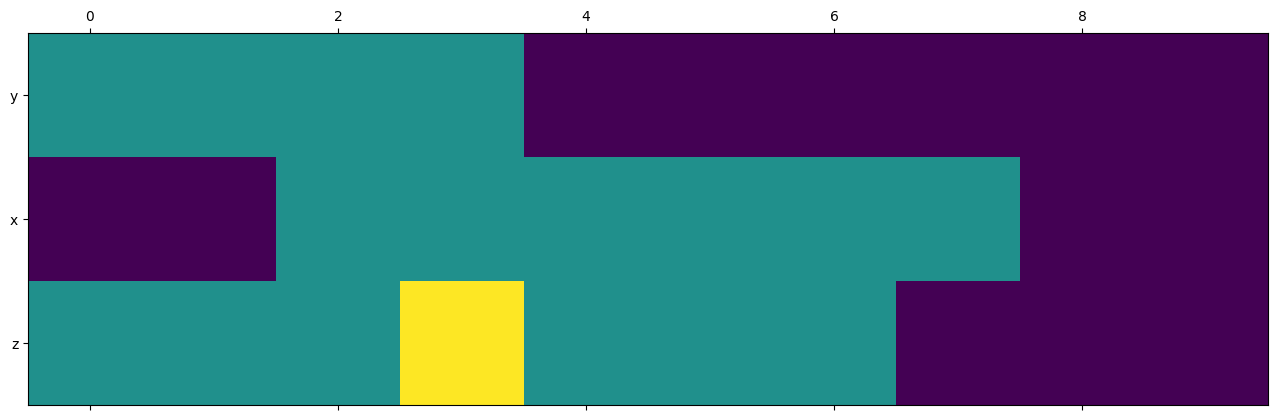

In [58]:
plt.matshow(grid)
plt.yticks(np.arange(len(grid.index)), labels=grid.index)
plt.show()

# Utils
`epitope_aligner` also includes functions to generate random sequences and epitopes.
`random_seq` returns a random sequence of given amino acids with a specified length. By default the 20 amino acids are used as capital letters. You could use a different set of characters or increase the probability of specific characters by including them multiple times in `AAs`.

In [3]:
from epitope_aligner import utils

# Random sequence, length 10
seq1 = utils.random_seq(seq_length=10)
print(seq1)

# Random sequence of As and Bs where B is twice as common
seq2 = utils.random_seq(seq_length=30, AAs= "ABB")
print(seq2)


YVPWQRWGPG
ABABABBBAABBBBBABBBBBBABABBBAB


We can create a set of random epitopes based on a given sequence. We specify the min and maximum length of these epitopes with the `epitope_lengths` argument which takes a tuple. We also have to define the coordinate system we're using.

In [4]:
utils.random_epitopes(
    sequence=seq1,
    n=10,
    epitope_lengths=(2,6),
    index=0,
    includeend=False
)

,start,end,seq,length
0,5,8,RWG,3
1,1,5,VPWQ,4
2,4,8,QRWG,4
3,3,6,WQR,3
4,2,5,PWQ,3
5,3,8,WQRWG,5
6,2,5,PWQ,3
7,3,5,WQ,2
8,1,4,VPW,3
9,5,9,RWGP,4


We can also introduce random gaps to a sequence to simulate an aligned version of the sequence. This is really only useful for testing. `gap_prob` is the probability of introducing a gap at each position. `gap_size_interval` is a tuple of the minimum and maximum size of gaps to introduce.

In [6]:
utils.random_gaps(
    seq=seq1,
    gap_prob=0.3,
    gap_size_interval=(1,3)
)

'Y-VPW-QRWG-P--G'

# Conclusion
Those are all the functions of `epitope_aligner`! If you have any trouble with them, spot a bug, or want to requests something new; please open an [issue](https://github.com/BarinthusBio/epitope_aligner/issues) on github. See the quick start for an example use case of `epitope_aligner` that shows off some of what you can do with it.